# Importing Libraries

In [1]:
import os
import pandas as pd
import statistics
import numpy as np


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB


from tqdm.auto import tqdm
import seaborn as sns

import joblib

sns.set(rc={'figure.figsize':(10,5)})
np.random.seed(1)


# Data Loading

In [2]:
def read_files(category):
    """
    Input: State a category to pick all the messages from
    Output: A dataset with two columns: text of the message, and a tag of the category associated to the message
    """
    files_content_list = []
    category_path = os.path.join('dataset', category)
    files_names_list = os.listdir(category_path)
    for file_name in tqdm(files_names_list):
        file_path = os.path.join(category_path, file_name)
        content = open(file_path,'r', errors='ignore').read()
        files_content_list.append(content)
        df_files_content = pd.DataFrame(files_content_list, columns=['Text']) 
        df_files_content['Category'] = category
    return df_files_content


In [3]:
categories_list = next(os.walk('dataset'))[1]
df_list = []
for category in tqdm(categories_list):
    df_list.append(read_files(category))
df = pd.concat(df_list)
df = df.reset_index(drop=True)
#df = df[0:10]  #todo remove 
df 

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/593 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/609 [00:00<?, ?it/s]

  0%|          | 0/596 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

,Text,Category
0,\nIn article <C4KvJF.4qo@well.sf.ca.us> metare...,exploration
1,Article-I.D.: cs.constants_733694246\n\n\nCONS...,exploration
2,Article-I.D.: cs.controversy_733694426\n\n\nCO...,exploration
3,Article-I.D.: cs.groups_733694492\n\n\nSPACE A...,exploration
4,Article-I.D.: cs.astronaut_733694515\n\n\nHOW ...,exploration
...,...,...
3888,\nAs quoted from <1993Apr17.025258.7013@micros...,weapons
3889,\nIn article <2071@rwing.UUCP> pat@rwing.UUCP ...,weapons
3890,07:24:55 GMT\n <1qjmnuINNlmd@cl...,weapons
3891,\nAs quoted from <1993Apr18.000152.2339@gnv.if...,weapons


# Understanding the data

In [4]:
#It seems like there are a few messages duplicated
unique_messages = len(df['Text'].unique())
total_messages = df.shape[0]
print(f'The number of repetated messages is : {total_messages - unique_messages}')

#We are going to drop those that are repeated within the same category
df_unique = df.drop_duplicates(subset=['Text', 'Category'])
print(f'The number of dropped messages is: {total_messages - df_unique.shape[0]}')

The number of repetated messages is : 20
The number of dropped messages is: 19


In [5]:
#How many registers do we have per class?
df_unique["Category"].value_counts()
#The classes seem to be pretty well balanced

politics          603
transportation    594
exploration       592
headhunters       589
weapons           546
logistics         485
intelligence      465
Name: Category, dtype: int64

<AxesSubplot:xlabel='Category', ylabel='Words'>

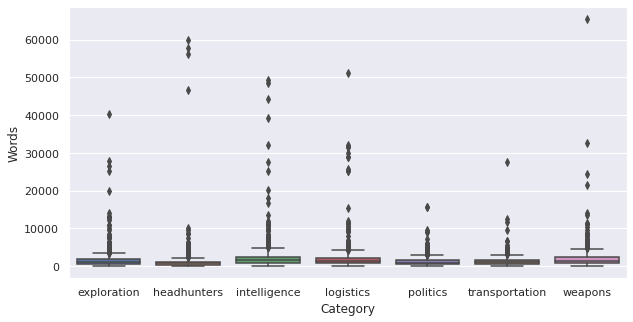

In [6]:
#Let´s look at the number of words per message
df['Words'] = df['Text'].apply(len)
sns.boxplot(x="Category", y="Words", data=df)
#We have outliers for all the categories, and don´t allow us to see well the distribution of the data 

<AxesSubplot:xlabel='Category', ylabel='Words'>

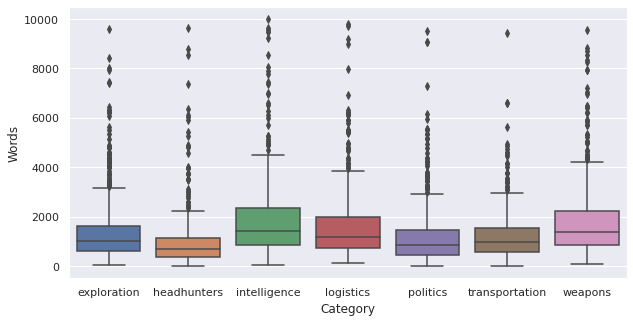

In [7]:
#We are going to zoom in the registers with less than 10k words
sns.boxplot(x="Category", y="Words", data=df[df['Words']<10000])


#One option for the future could be to check if the model accuracy improves by dropping the registers with more than 10k words
df[df['Words']>10000]. 



# Data Cleaning

In [8]:
#Let´s have a look at a raw text
df_unique["Text"].head(1).values

array(['\nIn article <C4KvJF.4qo@well.sf.ca.us> metares@well.sf.ca.us (Tom Van Flandern) writes:\n>crb7q@kelvin.seas.Virginia.EDU (Cameron Randale Bass) writes:\n>> Bruce.Scott@launchpad.unc.edu (Bruce Scott) writes:\n>>> "Existence" is undefined unless it is synonymous with "observable" in\n>>> physics.\n>> [crb] Dong ....  Dong ....  Dong ....  Do I hear the death-knell of\n>> string theory?\n>\n>     I agree.  You can add "dark matter" and quarks and a lot of other\n>unobservable, purely theoretical constructs in physics to that list,\n>including the omni-present "black holes."\n>\n>     Will Bruce argue that their existence can be inferred from theory\n>alone?  Then what about my original criticism, when I said "Curvature\n>can only exist relative to something non-curved"?  Bruce replied:\n>"\'Existence\' is undefined unless it is synonymous with \'observable\' in\n>physics.  We cannot observe more than the four dimensions we know about."\n>At the moment I don\'t see a way to defen

It comes with many characters that are going to difficult the classification. It needs cleaning. 

We are going to create a data cleaning pipeline that will allow us to clean the messages from the training set, as well as those that will come in the future


In [9]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        """
        Text preprocessing transformer to clean the messages
        """
        
    def fit(self, X, y=None):
        return self #returns the same

    def transform(self, X, y=None):
        X_transform = X.map(lambda s:self.__preprocess(s))
        return X_transform
    
    def __preprocess(self, sentence):
        """
        Input: String of text
        Output: String of text with only words and not other characters 
        """
        import re
        from nltk.tokenize import RegexpTokenizer
        from nltk.stem import WordNetLemmatizer,PorterStemmer
        from nltk.corpus import stopwords
        #from spellchecker import SpellChecker #It takes way too long (>1h)

        #self.spell = SpellChecker() #It takes way too long (>1h)
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer() 

        sentence = str(sentence) 
        sentence = sentence.lower()
        sentence = sentence.replace('{html}',"") 
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', sentence)
        rem_url = re.sub(r'http\S+', '',cleantext)
        rem_num = re.sub('[0-9]+', '', rem_url)
        rem__ = re.sub('_+', '', rem_num)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(rem__)  
        filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
        #corrected_words = [self.spell.correction(w) for w in filtered_words] #It takes way too long (>1h)
        stem_words = [self.stemmer.stem(w) for w in filtered_words]
        lemma_words = [self.lemmatizer.lemmatize(w) for w in stem_words]
        return " ".join(lemma_words)

In [10]:
#To ease the process of experimenting with different options 
#we are going to use sklearn´s pipelines

pipeline_tranform_data = Pipeline([
        ('Text_Preprocess', TextPreprocessor()), 
        ('TFidVector', TfidfVectorizer()) #max_features=1000, )) 
    ])

Text_Clean = pipeline_tranform_data.fit_transform(df_unique["Text"])

In [11]:
X = Text_Clean
y = df_unique["Category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [12]:
# A list with all the classifiers to be tested. We are going to implement the models out-of-box
# Hyperparameters will be fine tune later on
classifiers_to_test = [
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier()
]

classifiers_list = []
scores_list = []

for classifier in classifiers_to_test:
    
    classifier_name = str(type(classifier)).split(".")[-1][:-2] #Getting the name of the classifier
    classifiers_list.append(classifier_name)
    
    score = statistics.mean(
                cross_val_score(
                    estimator=classifier, 
                    X=X_train, 
                    y=y_train,
                    cv=5, 
                    scoring='accuracy'))
    scores_list.append(score)
    
    print(f"{classifier_name}: Accuracy is: {score}")
    
data = {'Accuracy': scores_list}
models_results = pd.DataFrame(index=classifiers_list, data=data)
models_results.sort_values(by='Accuracy')

SVC: Accuracy is: 0.9486914378029079
DecisionTreeClassifier: Accuracy is: 0.6931257491271041
RandomForestClassifier: Accuracy is: 0.8944765230079733
AdaBoostClassifier: Accuracy is: 0.6763447808640367


,Accuracy
AdaBoostClassifier,0.676345
DecisionTreeClassifier,0.693126
RandomForestClassifier,0.894477
SVC,0.948691


In [13]:
#According to the results of the previous comparison, we are going to pick the RandomForest
#Previously we have tried SVC, but it does not generalize well.


#Let´s adjust the hyperparameters
n_estimators = [1000]
max_features = ['auto']
max_depth = [3, 5, 7]
min_samples_leaf = [2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf
              }

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(
                estimator = rf, 
                param_distributions = random_grid, 
                n_iter = 100,
                cv = 3, 
                scoring='accuracy',
                verbose=5,
                n_jobs = -1)

rf_random.fit(X_train, y_train)  
print(rf_random.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s finished


{'n_estimators': 1000, 'max_features': 'auto', 'max_depth': 3}


In [14]:
print("Scores for the Train Dataset: ")
y_train_pred = rf_random.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
print("Accuracy: %.2f%%" % (accuracy_train * 100.0))

print("- - - - - - - - - - ")

print("Scores for the Test Dataset: ")
y_test_pred = rf_random.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Accuracy: %.2f%%" % (accuracy_test * 100.0))



Scores for the Train Dataset: 
Accuracy: 78.93%
- - - - - - - - - - 
Scores for the Test Dataset: 
Accuracy: 77.55%


In [15]:
print(confusion_matrix(y_test,y_test_pred))


[[101  10   0   0   1   6   0]
 [  2 113   0   0   0   3   0]
 [ 13  15  13   2   4  34  12]
 [  3  13   0  64   3  11   3]
 [  0   8   0   0 113   0   0]
 [  0   8   0   0   0 109   2]
 [  4   6   0   0   2   9  88]]


In [16]:
print(classification_report(y_test,y_test_pred))


                precision    recall  f1-score   support

   exploration       0.82      0.86      0.84       118
   headhunters       0.65      0.96      0.78       118
  intelligence       1.00      0.14      0.25        93
     logistics       0.97      0.66      0.79        97
      politics       0.92      0.93      0.93       121
transportation       0.63      0.92      0.75       119
       weapons       0.84      0.81      0.82       109

      accuracy                           0.78       775
     macro avg       0.83      0.75      0.73       775
  weighted avg       0.82      0.78      0.75       775



In [ ]:
#Considering that there are 7 classes
#We consider that an accuracy of a 77,8% in the test set is a good result

In [17]:
joblib.dump(rf_random, "model.pkl") 
joblib.dump(pipeline_tranform_data, "pipeline_tranform_data.pkl") 


['pipeline_tranform_data.pkl']